# Mobile money transactions Fraud Detection
**Acknowledgements: This dataset is from Kaggle.
For details, see https://www.kaggle.com/ntnu-testimon/paysim1/home**

- [About this dataset](#About-this-dataset)
- [Before you start](#Before-you-start)
- [Setup](#Setup)
- [Data Processing](#Data-Processing)
  * [Load](#Load-data)
  * [Explore](#Explore-the-dataset)
  * [Feature Engineering](#Feature-Engineering)
  * [Prepare dataset for SageMaker XGBoost](#Prepare-dataset-for-SageMaker-XGBoost)
- [Training the XGBoost model](#Training-the-XGBoost-model)
- [Predict Using Batch transform](#Predict-Using-Batch-transform)
- [Predict using API inference endpoint](#Predict-using-API-inference-endpoint)



  


## About this dataset


There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.
Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

### Headers

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
Past Research

There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932).

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

### Acknowledgements

This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016



## Before you start
1. Manually Download the dataset from Kaggle https://www.kaggle.com/ntnu-testimon/paysim1/downloads/PS_20174392719_1491204439457_log.csv/2 and upload to s3

## Setup

In [1]:
### Download data from S3

In [9]:

tmpdir="."



In [3]:
## This is to ensure that the right libraries  are installed...
!pip install -r requirements.txt

A subdirectory or file . already exists.
Error occurred while processing: ..


In [10]:
import os
local_input_zip=os.path.join(tmpdir, "paysim.zip")

#!aws s3 cp $s3_source_data $local_input_zip

In [6]:
!unzip -o $local_input_zip -d $tmpdir

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Data Processing

### Load data
Load the csv file into pandas

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the data into pandas

In [12]:
data = pd.read_csv(os.path.join(tmpdir,'PS_20174392719_1491204439457_log.csv'))

### Explore the dataset 

In [13]:
data.head(n=10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [10]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


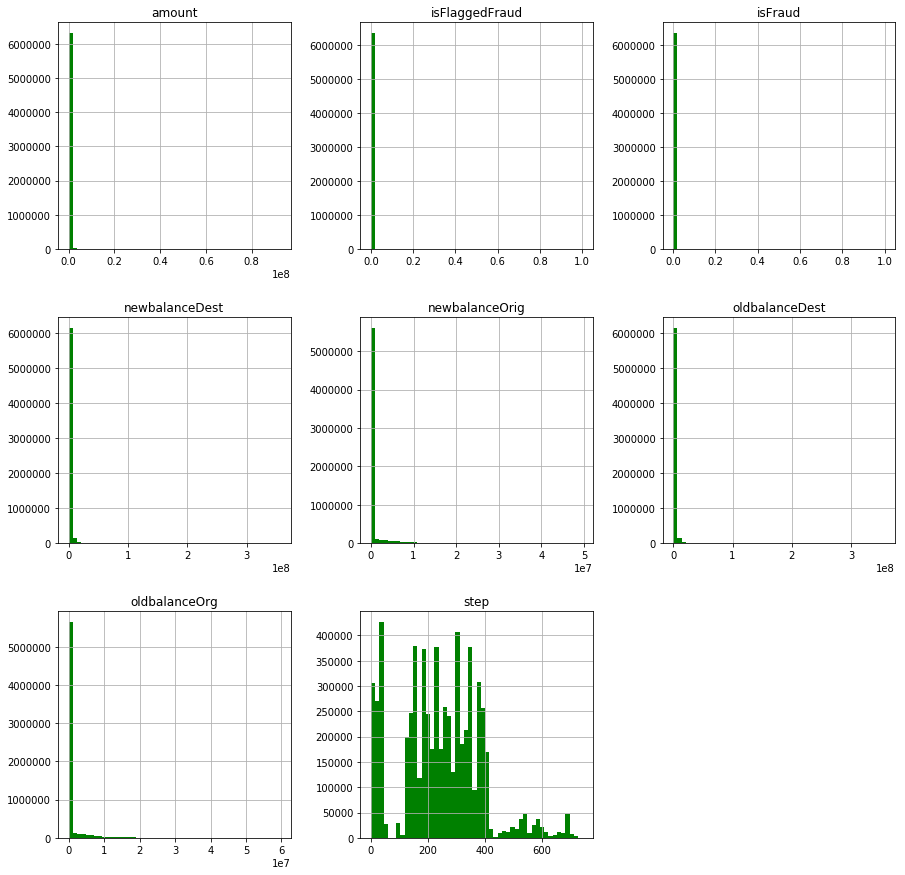

In [11]:
data.hist (bins=50, figsize=(15,15), color = 'green')
plt.show()

Distribution of transactions wrt to source account

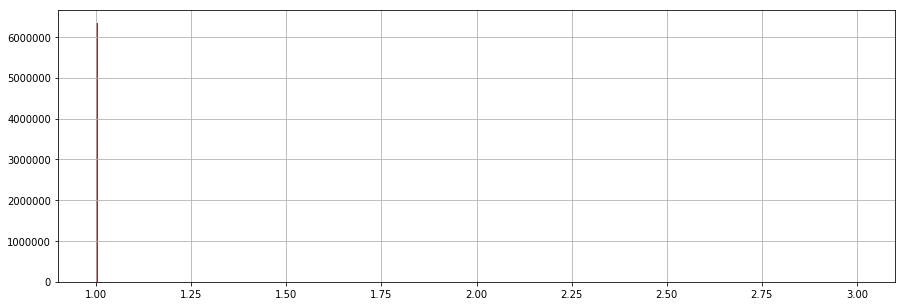

In [12]:
data['nameOrig'].value_counts().hist (bins=500, figsize=(15,5), color = 'red')
plt.show()

In [13]:
data['nameOrig'].value_counts().describe()

count    6.353307e+06
mean     1.001466e+00
std      3.832002e-02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+00
Name: nameOrig, dtype: float64

Distribution of transactions wrt to dest account

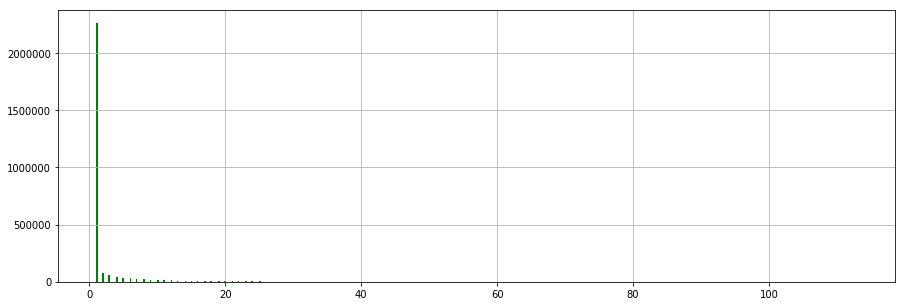

In [14]:
data['nameDest'].value_counts().hist (bins=500, figsize=(15,5), color = 'green')
plt.show()

In [15]:
data.sort_values(by=['step', 'nameOrig']).head(n=20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2332,1,DEBIT,2655.04,C10001825,21214.00,18558.96,C1850180796,1116396.05,1268668.92,0,0
1421,1,PAYMENT,2444.49,C1002041276,31454.00,29009.51,M485475507,0.00,0.00,0,0
1956,1,PAYMENT,1246.74,C1002911155,1468.00,221.26,M1467977993,0.00,0.00,0,0
100,1,PAYMENT,871.75,C1003206025,19869.00,18997.25,M989889899,0.00,0.00,0,0
2200,1,PAYMENT,264.93,C1003307628,0.00,0.00,M1595188851,0.00,0.00,0,0
247,1,PAYMENT,9029.12,C1003755748,25480.00,16450.88,M1414013111,0.00,0.00,0,0
994,1,PAYMENT,1617.90,C1004430079,507865.00,506247.10,M1379148981,0.00,0.00,0,0
883,1,CASH_OUT,59390.46,C100445376,0.00,0.00,C977993101,73791.34,965870.05,0,0
1007,1,PAYMENT,1213.64,C1006624255,86078.00,84864.36,M1721180011,0.00,0.00,0,0
1297,1,CASH_IN,377287.80,C100708535,5110945.41,5488233.21,C985934102,2256095.33,971418.91,0,0


Explore the class distribution

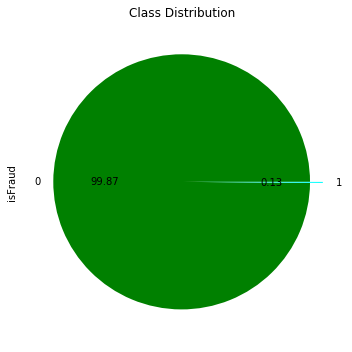

In [16]:
data.isFraud.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5), colors=["green","cyan"], explode=[0,.1])
plt.title('Class Distribution')
plt.tight_layout()

#### Highly imbalanced dataset
Since this is a highly imbalanced dataset, use AUCPR instead of AUC under ROC as the eval metric

View Correlation heatmap

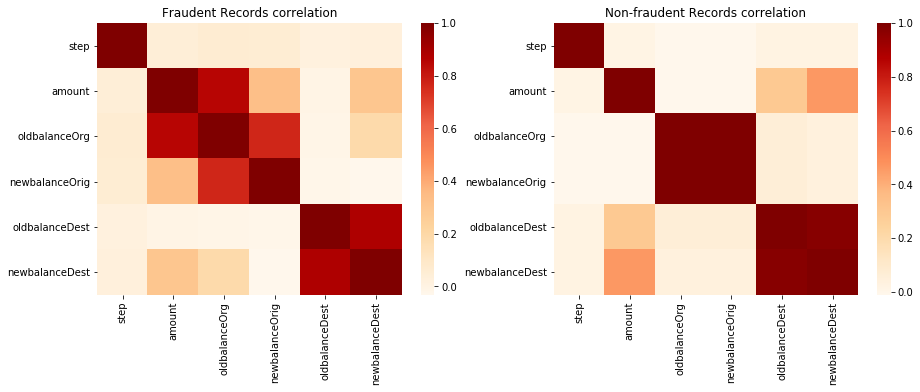

In [17]:
fig, ax = plt.subplots( 1,2, figsize=(15,5))

ax[0].set_title("Fraudent Records correlation")
sns.heatmap(data.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="OrRd", ax=ax[0])

ax[1].set_title("Non-fraudent Records correlation")
sns.heatmap(data.query('isFraud == 0').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="OrRd", ax=ax[1])
plt.show()

#### Source Amount and destination difference in balance dont match
When the record has the isFlaggedFraud = 1, this means that the transaction was detected and stopped from being processed, that is the reason why it didn't affect the account destination/origin (previous value). 

**Note:** there is not record of balance from clients that start with M (Merchants).



### Feature Engineering

#### Drop Correlated features

In [14]:
data_clean = data
data_clean = data_clean.drop(["newbalanceOrig", "newbalanceDest", "isFlaggedFraud" ],1)

**Note** If you dont remove the newbalanceDest you will get better results > 90% AUCPR. But I would think that is not entirely fair because in the dataset the source amount transfered doesnt add up to the destination increase in balance if the transfer is stopped. This happens whena the banks modelling system which detects a potential fraud transaction

#### Add new features

In [15]:
data_clean["isMerchantTransOrig"] = data_clean["nameOrig"].str.startswith('M').astype(int) 
data_clean["isMerchantTransDest"] = data_clean["nameDest"].str.startswith('M').astype(int) 

data_clean["isMerchantTrans"] = data_clean["isMerchantTransOrig"] |  data_clean["isMerchantTransDest"]

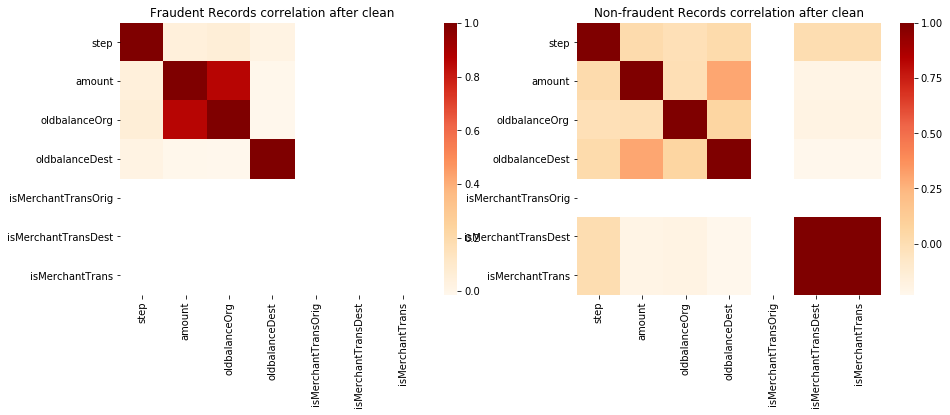

In [20]:
fig, ax = plt.subplots( 1,2, figsize=(15,5))


ax[0].set_title("Fraudent Records correlation after clean")
sns.heatmap(data_clean.query('isFraud == 1').drop(['isFraud'],1).corr(),  cmap="OrRd", ax=ax[0])

ax[1].set_title("Non-fraudent Records correlation after clean")
sns.heatmap(data_clean.query('isFraud == 0').drop(['isFraud'],1).corr(),  cmap="OrRd", ax=ax[1])
plt.show()

### Prepare dataset for SageMaker XGBoost

#### Column order - Labels in first column
Recorder columns such that the label is the first column. This is because of the format expected by XGBoost SageMaker implementation, for more details see https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

In [16]:
cols = data_clean.drop(["isFraud"],1).columns.tolist()
cols.insert(0, "isFraud")
data_clean = data_clean[cols]
data_clean.head(n=5)

,isFraud,step,type,amount,nameOrig,oldbalanceOrg,nameDest,oldbalanceDest,isMerchantTransOrig,isMerchantTransDest,isMerchantTrans
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,M1979787155,0.0,0,1,1
1,0,1,PAYMENT,1864.28,C1666544295,21249.0,M2044282225,0.0,0,1,1
2,1,1,TRANSFER,181.00,C1305486145,181.0,C553264065,0.0,0,0,0
3,1,1,CASH_OUT,181.00,C840083671,181.0,C38997010,21182.0,0,0,0
4,0,1,PAYMENT,11668.14,C2048537720,41554.0,M1230701703,0.0,0,1,1


#### Unimportant non numerical column drop
XGBoost only works with numerical values, drop non-numerical columns source/des accounts 

In [17]:
data_clean = data_clean.drop([ 'nameOrig', 'nameDest'],1)

#### Onehot encode categorical columns 
XG boost only works with numerical values, so translate categorical columns into one-hot vector

In [18]:
data_clean =  pd.get_dummies(data_clean,prefix=['transaction_type'],  columns=['type']) 
data_clean.head(n=5)

,isFraud,step,amount,oldbalanceOrg,oldbalanceDest,isMerchantTransOrig,isMerchantTransDest,isMerchantTrans,transaction_type_CASH_IN,transaction_type_CASH_OUT,transaction_type_DEBIT,transaction_type_PAYMENT,transaction_type_TRANSFER
0,0,1,9839.64,170136.0,0.0,0,1,1,0,0,0,1,0
1,0,1,1864.28,21249.0,0.0,0,1,1,0,0,0,1,0
2,1,1,181.00,181.0,0.0,0,0,0,0,0,0,0,1
3,1,1,181.00,181.0,21182.0,0,0,0,0,1,0,0,0
4,0,1,11668.14,41554.0,0.0,0,1,1,0,0,0,1,0


#### Train test set split
Split the dataset into train, test and validation set

In [19]:
import sklearn
from sklearn.model_selection import train_test_split, learning_curve

train_val, test = train_test_split(data_clean, test_size = 0.2, random_state = 777)
train, validation = train_test_split(train_val, test_size = 0.2, random_state = 777)

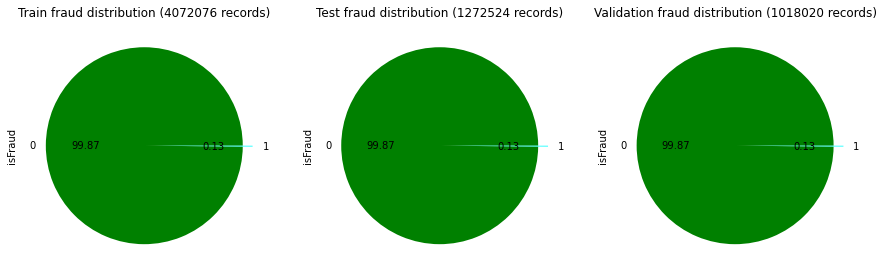

In [20]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

train.isFraud.value_counts().plot.pie(autopct='%.2f', ax = ax[0], colors=["green","cyan"], explode=[0,.1])
ax[0].set_title('Train fraud distribution ({} records)'.format(train.shape[0]))

test.isFraud.value_counts().plot.pie(autopct='%.2f', ax = ax[1], colors=["green","cyan"], explode=[0,.1])
ax[1].set_title('Test fraud distribution ({} records)'.format(test.shape[0]))

validation.isFraud.value_counts().plot.pie(autopct='%.2f', ax = ax[2], colors=["green","cyan"], explode=[0,.1])
ax[2].set_title('Validation fraud distribution ({} records)'.format(validation.shape[0]))

plt.show() 

In [21]:
train.head()

,isFraud,step,amount,oldbalanceOrg,oldbalanceDest,isMerchantTransOrig,isMerchantTransDest,isMerchantTrans,transaction_type_CASH_IN,transaction_type_CASH_OUT,transaction_type_DEBIT,transaction_type_PAYMENT,transaction_type_TRANSFER
2434049,0,203,16894.96,443240.04,197879.16,0,0,0,1,0,0,0,0
6069079,0,514,2803.27,0.00,0.00,0,1,1,0,0,0,1,0
3941628,0,286,12518.66,50718.00,0.00,0,1,1,0,0,0,1,0
2651943,0,209,25650.28,0.00,1384324.66,0,0,0,0,1,0,0,0
3384259,0,255,418089.50,7037.00,0.00,0,0,0,0,0,0,0,1


In [22]:
import os

trainfile=os.path.join(tmpdir, "train_paysim.csv")
testfile=os.path.join(tmpdir,"test_paysim.csv")
validationfile=os.path.join(tmpdir,"validation_paysim.csv")

Write the records to file

In [23]:
train.to_csv(path_or_buf=trainfile, sep=',', na_rep='', header=False, index=False,  mode='w', encoding='UTF-8', quotechar='"', line_terminator='\n', decimal='.')
test.to_csv(path_or_buf=testfile, sep=',', na_rep='', header=False, index=False,  mode='w', encoding='UTF-8', quotechar='"', line_terminator='\n', decimal='.')
validation.to_csv(path_or_buf=validationfile, sep=',', na_rep='', header=False, index=False,  mode='w', encoding='UTF-8', quotechar='"', line_terminator='\n', decimal='.')

'head' is not recognized as an internal or external command,
operable program or batch file.


Copy the data to s3 into train and test channels


## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import xgboost as xgb
import os
import time

# Load the data from the pre-split files
train = pd.read_csv("train_paysim.csv", header=None)
validation = pd.read_csv("validation_paysim.csv", header=None)
test = pd.read_csv("test_paysim.csv", header=None)

# Separate features and labels
# First column is the label
y_train = train.iloc[:, 0]  # Select first column for labels
X_train = train.iloc[:, 1:]  # All other columns for features

y_val = validation.iloc[:, 0]  # Select first column for labels
X_val = validation.iloc[:, 1:]  # All other columns for features

y_test = test.iloc[:, 0]  # Select first column for labels
X_test = test.iloc[:, 1:]  # All other columns for features


# Calculate scale_pos_weight for handling class imbalance
#scale_pos_weight = len(y_train) / (y_train.sum() * 1.0)
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# Define hyperparameters (equivalent to SageMaker parameters)
params = {
    "max_depth": 5,
    "eta": 0.2,
    "gamma": 4,
    "min_child_weight": 6,
    "subsample": 0.7,
    "objective": "binary:logistic",  # Adjust objective if required
    "eval_metric": "auc",
    "silent": 0,
    "scale_pos_weight": scale_pos_weight,  # Handle class imbalance
}

num_round = 50

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model
print("Training the XGBoost model locally...")
start_time = time.time()
evals = [(dtrain, 'train'), (dval, 'validation')]
model = xgb.train(params, dtrain, num_boost_round=num_round, evals=evals)

print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# Save the model locally
model_file = "xgboost_model.json"
model.save_model(model_file)
print(f"Model saved to {model_file}")

# Load the model for inference
loaded_model = xgb.Booster()
loaded_model.load_model(model_file)
print("Model loaded successfully.")

Training the XGBoost model locally...
[11:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.98750	validation-auc:0.98747
[1]	train-auc:0.99081	validation-auc:0.99065
[2]	train-auc:0.99197	validation-auc:0.99160
[3]	train-auc:0.99211	validation-auc:0.99187
[4]	train-auc:0.99394	validation-auc:0.99333
[5]	train-auc:0.99646	validation-auc:0.99628
[6]	train-auc:0.99702	validation-auc:0.99702
[7]	train-auc:0.99709	validation-auc:0.99696
[8]	train-auc:0.99784	validation-auc:0.99759
[9]	train-auc:0.99789	validation-auc:0.99771
[10]	train-auc:0.99798	validation-auc:0.99786
[11]	train-auc:0.99804	validation-auc:0.99792
[12]	

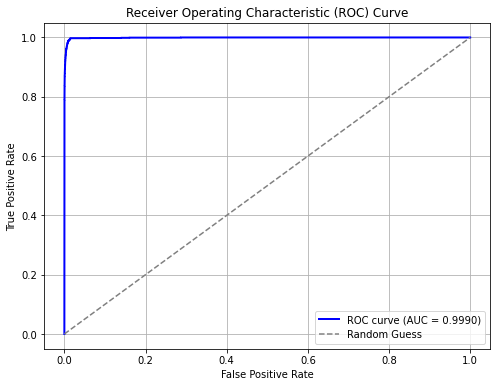

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Create Model

In [26]:
# Evaluate on the test set
y_pred = loaded_model.predict(dtest)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC on test set: {roc_auc:.4f}")

# Convert probabilities to binary predictions (threshold of 0.5)
y_pred_binary = (y_pred > 0.5)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Save predictions to a file
output_file = "test_predictions.csv"
pd.DataFrame({'actual': y_test, 'predicted': y_pred}).to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")


ROC AUC on test set: 0.9990
Precision: 0.0719
Recall: 0.9976
F1 Score: 0.1341
Predictions saved to test_predictions.csv


In [36]:
# Manually input a single data point (replace with your feature values)
# Example: Let's assume the dataset has 3 features
single_sample = pd.DataFrame({
    0: [0],  # Feature 1 value
    1: [238],  # Feature 2 value
    2: [797189.27],  # Feature 3 value
    3: [0.0],  # Feature 3 value
    4: [2032573.39],  # Feature 3 value
    5: [0],  # Feature 3 value
    6: [0],  # Feature 3 value
    7: [0],  # Feature 3 value
    8: [0],  # Feature 3 value
    9: [0],  # Feature 3 value
    10: [0],  # Feature 3 value
    11: [0],  # Feature 3 value
    #12: [1],  # Feature 3 value
    
    
    #0,238,797189.27,0.0,2032573.39,0,0,0,0,0,0,0,1

    # Add more features as required based on your dataset
})

# If your dataset has more features, make sure to add them in the dictionary


# Convert the single input sample to DMatrix
dtest_single = xgb.DMatrix(single_sample)


# Get the predicted probability (for binary classification)
y_pred_single = loaded_model.predict(dtest_single)

# If you need binary prediction (0 or 1), apply a threshold (e.g., 0.5)
y_pred_binary_single = (y_pred_single > 0.5)

# Print the predicted probability and binary prediction
print(f"Predicted probability: {y_pred_single[0]:.4f}")
print(f"Predicted label (binary): {y_pred_binary_single[0]}")



Predicted probability: 1.0000
Predicted label (binary): True


## Predict Using Batch transform

This is a good use of batch transform where you simply evalute the model  before deloying it as an API

In [ ]:
import os

batchfileinput=os.path.join(tmpdir, "batchvalidation.csv")
batchfileresults=os.path.join(tmpdir, "batchvalidation_results.csv")

In [ ]:
%%time
import json
from itertools import islice
import math
import struct

file_name = testfile 
with open(file_name, 'r') as f:
    lines = f.readlines()
    
input_records = [",".join(l.strip().split(",")[1:]) for l in lines]
labels = [int(l.split(",")[0]) for l in lines]


with open(batchfileinput , "w") as f:
    f.writelines(["{}\n".format(item) for item in input_records])
                                          

In [ ]:
%%time
import boto3
import sagemaker
import json

fmttime= strftime("%Y-%m-%d-%H-%M-%S", gmtime())
input_key_file="batchvalidation.csv"
input_batch_key="{}/batchTransform/{}_input/{}".format(prefix, fmttime, input_key_file)
input_location = 's3://{}/{}'.format(bucket, input_batch_key)
output_batch_key = "{}/batchTransform/{}_output".format(prefix,fmttime)
output_location = 's3://{}/{}'.format(bucket, output_batch_key)


s3_client = boto3.client('s3')
s3_client.upload_file(batchfileinput, bucket, input_batch_key)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
    )
# To start a transform job:
transformer.transform(input_location, content_type='text/csv', split_type='Line')
# Then wait until transform job is completed
transformer.wait()

# To fetch validation result 
outputkey ='{}/{}.out'.format(output_batch_key, input_key_file)
print(outputkey)
s3_client.download_file(bucket, outputkey, batchfileresults)
with open(batchfileresults) as f:
    results = f.readlines()   
    predicted = [float(r) for r in results]
print("Sample transform result: {}".format(results[0]))

### Measurement using - AUCPR
Because the postive samples are underrepresented, measures such as AUC under ROC or accuracy inflate the numbers. So, use the AUC under the Precision Recall curve instead as it doesnt take into account True Negatives

In [31]:
import sklearn
micro_score = sklearn.metrics.average_precision_score(labels, predicted, average='micro',  sample_weight=None)
print("AUC under precision recall curve is {}".format(micro_score))

NameError: name 'labels' is not defined

## Predict using API inference endpoint
Now you are ready to deploy your model as an API..

#### Deploy Endpoint

In [ ]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

In [ ]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

#### Invoke your api to run inference

In [ ]:
runtime_client = boto3.client('runtime.sagemaker')

In [ ]:
%%time
import json
from itertools import islice
import math
import struct

file_name = testfile 
with open(file_name, 'r') as f:
    lines = f.readlines()
    
input_records = [",".join(l.strip().split(",")[1:]) for l in lines]
labels = [int(l.split(",")[0]) for l in lines]



In [ ]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
%%time
predicted = []
for record_chunks in chunks(input_records, 10000):
    formatted = "\n".join(record_chunks)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=formatted.encode('utf-8'))
    result = response['Body'].read()
    result = result.decode("utf-8")
    predicted.extend([float(r) for r in result.split(',')])
    
    print("Predicted {} out of {} so far ..".format(len(predicted), len(input_records)))


In [ ]:
import sklearn
    
macro_score = sklearn.metrics.average_precision_score(labels, predicted, average='macro',  sample_weight=None)

print("The AUC under precision recall curve is {}".format(micro_score, macro_score))

In [ ]:
confidence_threshold=.5

In [ ]:
confusion_matrix = sklearn.metrics.confusion_matrix(labels, pd.DataFrame(predicted) > confidence_threshold, labels=[1,0], sample_weight=None)
confusion_matrix

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(
        confusion_matrix, index=["Fraud", "Non-Fraud"], columns=["Fraud", "Non-Fraud"], 
)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt="d", cmap="tab10" )
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels, pd.DataFrame(predicted) > confidence_threshold, average=None)

#### Delete endpoint as this is just a demo..

In [ ]:
client.delete_endpoint(EndpointName=endpoint_name)

### Clean up local tmp directory

In [ ]:
!rm -rf $tmpdir

### Next Steps
This XGBoost model doesnt take into account the time series ( the step sequence). So inorder to improve the model, we will look at using Time Series Classification Techniques. 

**Coming soon.....**